<div class="alert alert-block alert-info">
<b></b></div>

# Оценка эффективности новой фичи

<div class="alert alert-block alert-info">
<b></b></div>

На сайте клининговой компании появилась новая фича - новостная лента в личном кабинете пользователя. Дата релиза 1 июня 2019 года.

**Для понимания эффективности новой фичи нужно:**
> 1. Посчитать показатели Retention Rate седьмого дня и ARPPU за два периода: до и после внедрения фичи.
> 2. Сформировать выводы по анализу.

In [1]:
# ! pip install psycopg2 

In [2]:
#импортируем необходимые библиотеки
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras
import seaborn as sns
from matplotlib import pyplot as plt

Для анализа эффективности фичи нужно подготовить данные по пользователям, зарегистрировавшимся в мае (до релиза) и в июне и сравнить показатели. 

Подготовку данных удобно вести параллельно для двух периодов. Датафреймы с индексом '05' относятся к пользователям с регистрацией  в мае, '06' - в июне.  

Определим количество зарегистрировавшихся пользователей в каждый день мая и июня.

Создадим функцию getRegisteredUsersCount(), в которой выполним SQL-запрос.

Подсчитаем количество зарегистрировавшихся пользователей registered_users_count_05 за май 2019 года и registered_users_count_06 за июнь 2019 года в разрезе registration_date — дней регистрации.

Конструкция pd.DataFrame(getRegisteredUsersCount()) позволяет выполнить функцию запроса, а затем записать полученные данные в датафрейм.

In [3]:
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count_05 = pd.DataFrame(getRegisteredUsersCount())

In [4]:
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count_06 = pd.DataFrame(getRegisteredUsersCount())

In [5]:
registered_users_count_05.head()

,registration_date,registered_users_count
0,2019-05-01,6516
1,2019-05-02,5309
2,2019-05-03,6266
3,2019-05-04,8639
4,2019-05-05,9787


In [6]:
registered_users_count_05.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       31 non-null     object
 1   registered_users_count  31 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 624.0+ bytes


Мы видим, что колонка registration_date имеет тип object (строковая переменная). Поэтому преобразуем её в тип datetime с помощью метода pd.to_datetime() и для удобства визуализации оставим только дату:

In [7]:
registered_users_count_05['registration_date'] = pd.to_datetime(registered_users_count_05['registration_date']).dt.date
registered_users_count_06['registration_date'] = pd.to_datetime(registered_users_count_06['registration_date']).dt.date

Посчитаем количество активных пользователей в разрезе когорт, причём в качестве когорты будет выступать дата регистрации. Таким образом, мы определим количество активных пользователей по дням в разрезе даты регистрации.

Сперва получим данные об активных пользователях из базы и подсчитаем по дням количество активных пользователей active_users_count  с указанием даты регистрации registration_date.

Создадим функцию getActiveUsersCountWithCohorts() и запишем данные, полученные с помощью этой функции, в датафреймы active_users_count_with_cohorts_05 и active_users_count_with_cohorts_06.

In [8]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts_05 = pd.DataFrame(getActiveUsersCountWithCohorts())

In [9]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts_06 = pd.DataFrame(getActiveUsersCountWithCohorts())

In [10]:
active_users_count_with_cohorts_05.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       961 non-null    object
 1   registration_date   961 non-null    object
 2   active_users_count  961 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 22.6+ KB


Преобразуем колонки 'activity_date','registration_date' в тип datetime и оставим для удобства только дату

In [11]:
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts_05[col] = pd.to_datetime(active_users_count_with_cohorts_05[col]).dt.date
    active_users_count_with_cohorts_06[col] = pd.to_datetime(active_users_count_with_cohorts_06[col]).dt.date

In [12]:
active_users_count_with_cohorts_05.head()

,activity_date,registration_date,active_users_count
0,2019-05-01,2019-05-01,2590
1,2019-05-02,2019-05-01,2146
2,2019-05-02,2019-05-02,2049
3,2019-05-03,2019-05-01,1637
4,2019-05-03,2019-05-02,1817


Чтобы рассчитать процент вернувшихся пользователей на определённый день, нам нужно сначала объединить попарно две таблицы с информацией о количестве зарегистрировавшихся пользователей и о количестве активных пользователей в зависимости от дня регистрации для мая и июня соответственно


In [13]:
retention_table_05 = active_users_count_with_cohorts_05.merge(registered_users_count_05,on=['registration_date'],how='left')
retention_table_05.head()

,activity_date,registration_date,active_users_count,registered_users_count
0,2019-05-01,2019-05-01,2590,6516
1,2019-05-02,2019-05-01,2146,6516
2,2019-05-02,2019-05-02,2049,5309
3,2019-05-03,2019-05-01,1637,6516
4,2019-05-03,2019-05-02,1817,5309


In [14]:
retention_table_06 = active_users_count_with_cohorts_06.merge(registered_users_count_06,on=['registration_date'],how='left')
retention_table_06.head()

,activity_date,registration_date,active_users_count,registered_users_count
0,2019-06-01,2019-06-01,1651,4833
1,2019-06-02,2019-06-01,1429,4833
2,2019-06-02,2019-06-02,1933,5255
3,2019-06-03,2019-06-01,1021,4833
4,2019-06-03,2019-06-02,1550,5255


Чтобы вычислить показатель Retention Rate, найдём отношение количества активных пользователей active_users_count к количеству зарегистрировавшихся пользователей registered_users_count в каждой когорте. Запишем полученное значение в колонку retention_rate

In [15]:
retention_table_05['retention_rate'] = retention_table_05['active_users_count'] / retention_table_05['registered_users_count']
retention_table_05.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-05-01,2019-05-01,2590,6516,0.397483
1,2019-05-02,2019-05-01,2146,6516,0.329343
2,2019-05-02,2019-05-02,2049,5309,0.385948
3,2019-05-03,2019-05-01,1637,6516,0.251228
4,2019-05-03,2019-05-02,1817,5309,0.342249


In [16]:
retention_table_06['retention_rate'] = retention_table_06['active_users_count']/ retention_table_06['registered_users_count']
retention_table_06.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-06-01,2019-06-01,1651,4833,0.341610
1,2019-06-02,2019-06-01,1429,4833,0.295676
2,2019-06-02,2019-06-02,1933,5255,0.367840
3,2019-06-03,2019-06-01,1021,4833,0.211256
4,2019-06-03,2019-06-02,1550,5255,0.294957


Добавим в получившиеся датафреймы колонку 'lifetime' с количеством дней прошедших с момента регистрации до определённого дня активности.

Нам нужно получить целое количество дней, поэтому значения в колонке с типом timedelta мы разделим на константу np.timedelta64(1,'D') и приведем тип к целому числу

In [17]:
retention_table_05['lifetime'] = retention_table_05['activity_date'] - retention_table_05['registration_date']
retention_table_05['lifetime'] = retention_table_05['lifetime']/np.timedelta64(1,'D')
retention_table_05['lifetime'] = retention_table_05['lifetime'].astype(int) 


In [18]:
retention_table_06['lifetime'] = retention_table_06['activity_date'] - retention_table_06['registration_date']
retention_table_06['lifetime'] = retention_table_06['lifetime']/np.timedelta64(1,'D')
retention_table_06['lifetime'] = retention_table_06['lifetime'].astype(int) 

In [19]:
retention_table_05.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime
0,2019-05-01,2019-05-01,2590,6516,0.397483,0
1,2019-05-02,2019-05-01,2146,6516,0.329343,1
2,2019-05-02,2019-05-02,2049,5309,0.385948,0
3,2019-05-03,2019-05-01,1637,6516,0.251228,2
4,2019-05-03,2019-05-02,1817,5309,0.342249,1


In [20]:
retention_table_06.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime
0,2019-06-01,2019-06-01,1651,4833,0.341610,0
1,2019-06-02,2019-06-01,1429,4833,0.295676,1
2,2019-06-02,2019-06-02,1933,5255,0.367840,0
3,2019-06-03,2019-06-01,1021,4833,0.211256,2
4,2019-06-03,2019-06-02,1550,5255,0.294957,1


Следующий шаг — сформировать сводные таблицы с когортами в мае и июне, которые позволят для каждой когорты оценить Retention Rate за порядковый день активности.

Результаты удобно визуализировать с помощью heatmap 

In [21]:
retention_pivot_05 = retention_table_05.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',\
                                                    aggfunc='sum')
retention_pivot_06 = retention_table_06.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',\
                                                    aggfunc='sum')

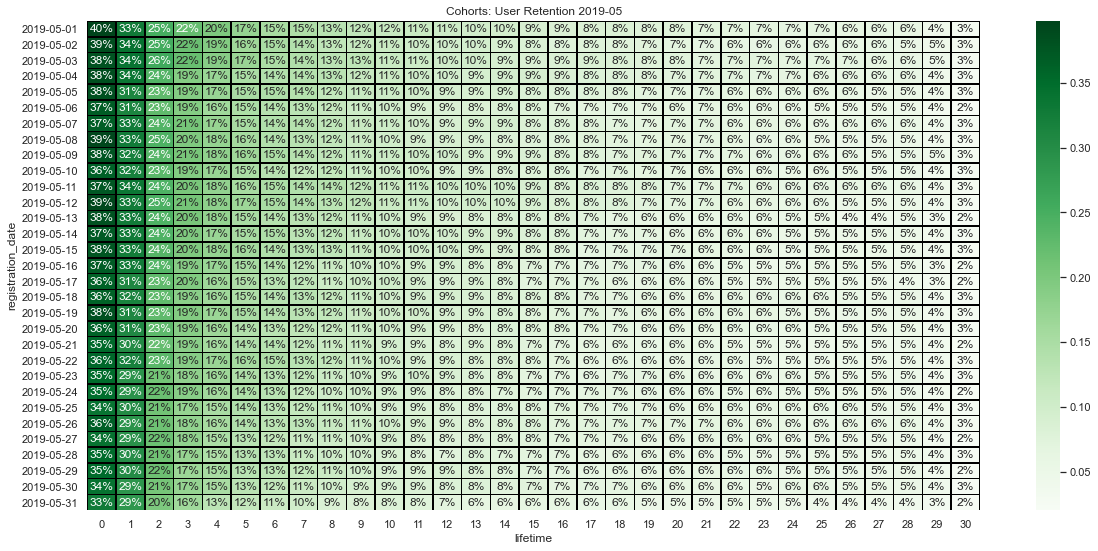

In [22]:
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Cohorts: User Retention 2019-05')
sns.heatmap(retention_pivot_05, mask=retention_pivot_05.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black', cmap="Greens");

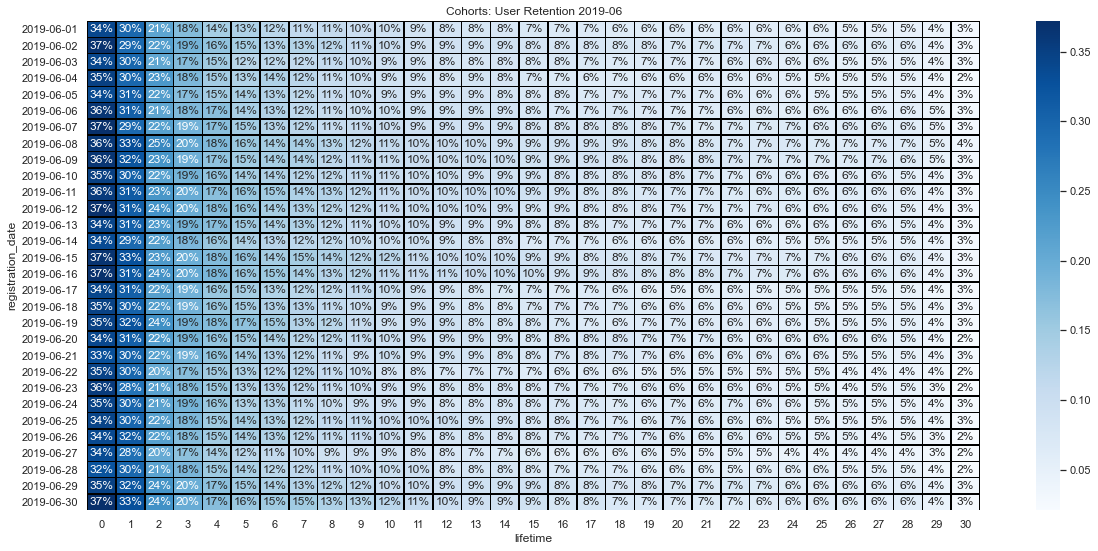

In [23]:
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Cohorts: User Retention 2019-06')
sns.heatmap(retention_pivot_06, mask=retention_pivot_06.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black', cmap="Blues");

Оценим изменение Retention Rate когорт на седьмой день до и после релиза фичи

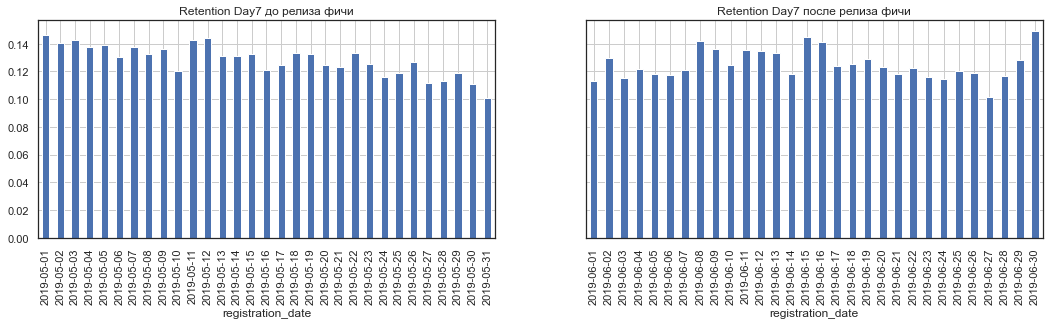

In [24]:
fig, axes=plt.subplots(1,2, figsize=(18,4), sharey=True)
retention_pivot_05[7].plot.bar(title="Retention Day7 до релиза фичи", grid=True, ax=axes[0])
retention_pivot_06[7].plot.bar(title="Retention Day7 после релиза фичи", grid=True, ax=axes[1]);

Визуально показатели Retention Day7 до и после релиза фичи остались примерно на том же уровне. Посмотрим более детально

In [25]:
print('\nДля майских когорт')
retention_pivot_05[7].describe()


Для майских когорт


count    31.000000
mean      0.128281
std       0.011065
min       0.100762
25%       0.120509
50%       0.130808
75%       0.136709
max       0.146255
Name: 7, dtype: float64

In [26]:
print('\nДля июньских когорт')
retention_pivot_06[7].describe()


Для июньских когорт


count    30.000000
mean      0.125151
std       0.010683
min       0.101808
25%       0.117848
50%       0.122547
75%       0.132268
max       0.149349
Name: 7, dtype: float64

Возвращаемость пользователей существенно не изменилась после релиза фичи.

Чтобы посчитать ARPU, напишем SQL-запрос, который позволит получить выручку по дням в разрезе когорт для пользователей, зарегистрировавшихся в мае и июне 2019 года. 

Этот запрос обернём в функцию getRevenue(), после чего получим данные по запросу и запишем в соответствующие датафреймы:
revenue_05 и revenue_06

In [27]:
def getRevenue():
    query = '''SELECT 
        re.date, 
        r.registration_date, 
        count(distinct(re.user_id)) as users_count_with_revenue, 
        sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue_05 = pd.DataFrame(getRevenue())

In [28]:
def getRevenue():
    query = '''SELECT 
        re.date, 
        r.registration_date, 
        count(distinct(re.user_id)) as users_count_with_revenue, 
        sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue_06 = pd.DataFrame(getRevenue())

In [29]:
revenue_05.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      912 non-null    object 
 1   registration_date         912 non-null    object 
 2   users_count_with_revenue  912 non-null    int64  
 3   revenue                   912 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6+ KB


In [30]:
revenue_05.head()

,date,registration_date,users_count_with_revenue,revenue
0,2019-05-01,2019-05-01,1672,2357.590
1,2019-05-02,2019-05-01,1420,514.679
2,2019-05-02,2019-05-02,1367,1629.140
3,2019-05-03,2019-05-01,1048,390.952
4,2019-05-03,2019-05-02,1164,533.608


Колонки с датами содержат тип object, произведём преобразование типов к datetime

In [31]:
for col in ['date','registration_date']:
    revenue_05[col] = pd.to_datetime(revenue_05[col]).dt.date
    revenue_06[col] = pd.to_datetime(revenue_06[col]).dt.date

In [32]:
users_count_05=registered_users_count_05['registered_users_count'].sum()
users_count_06=registered_users_count_06['registered_users_count'].sum()
print(f'В мае 2019 года в сервисе зарегистрировалось {users_count_05} пользователя, \
        а в июне {users_count_06} пользователя.\n')

r_05=round(revenue_05['revenue'].sum(),1)
r_06=round(revenue_06['revenue'].sum(),1)
print(f'Сумма выручки, которую принесли пользователи: \n\tзарегистрировавшиеся в мае {r_05}$,\n\
        \tзарегистрировавшиеся в июне {r_06}$.')

В мае 2019 года в сервисе зарегистрировалось 188943 пользователя,         а в июне 100423 пользователя.

Сумма выручки, которую принесли пользователи: 
	зарегистрировавшиеся в мае 121998.3$,
        	зарегистрировавшиеся в июне 79685.9$.


Следующий шаг — объединение данных из датафреймов revenue за май и июнь с соответствующими данными из датафреймов retention_table. Но прежде в датафреймах revenue следует изменить название колонки date на activity_date. Делаем это с тем, чтобы в дальнейшем объединять датафреймы по одинаковому названию колонок.

In [33]:
revenue_05 = revenue_05.rename(columns={'date':'activity_date'})
revenue_06 = revenue_06.rename(columns={'date':'activity_date'})

In [34]:
retention_table_with_revenue_05 = retention_table_05.merge(revenue_05,on=['registration_date','activity_date'],how='left')
retention_table_with_revenue_06 = retention_table_06.merge(revenue_06,on=['registration_date','activity_date'],how='left')

In [35]:
retention_table_with_revenue_05.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 960
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   activity_date             961 non-null    object 
 1   registration_date         961 non-null    object 
 2   active_users_count        961 non-null    int64  
 3   registered_users_count    961 non-null    int64  
 4   retention_rate            961 non-null    float64
 5   lifetime                  961 non-null    int32  
 6   users_count_with_revenue  912 non-null    float64
 7   revenue                   912 non-null    float64
dtypes: float64(3), int32(1), int64(2), object(2)
memory usage: 63.8+ KB


In [36]:
retention_table_with_revenue_06.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 930 entries, 0 to 929
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   activity_date             930 non-null    object 
 1   registration_date         930 non-null    object 
 2   active_users_count        930 non-null    int64  
 3   registered_users_count    930 non-null    int64  
 4   retention_rate            930 non-null    float64
 5   lifetime                  930 non-null    int32  
 6   users_count_with_revenue  833 non-null    float64
 7   revenue                   833 non-null    float64
dtypes: float64(3), int32(1), int64(2), object(2)
memory usage: 61.8+ KB


После объединения видим, что есть пропущенные значения. Это говорит о том, что не во все дни была выручка с пользователей.

Произведём замену пропущенных значений на 0 с помощью функции fillna().

In [37]:
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue_05[col] = retention_table_with_revenue_05[col].fillna(0)
    retention_table_with_revenue_06[col] = retention_table_with_revenue_06[col].fillna(0)

Преобразуем тип в колонке users_count_with_revenue в целочисленный

In [38]:
retention_table_with_revenue_05['users_count_with_revenue'] = retention_table_with_revenue_05['users_count_with_revenue'].astype(int)
retention_table_with_revenue_06['users_count_with_revenue'] = retention_table_with_revenue_06['users_count_with_revenue'].astype(int)

Добавим в получившиеся датафреймы колонку 'arppu' с информацией о величине средней выручки на одного уникального платящего пользователя.

In [39]:
retention_table_with_revenue_05['arppu']=retention_table_with_revenue_05['revenue']/retention_table_with_revenue_05['users_count_with_revenue']
retention_table_with_revenue_06['arppu']=retention_table_with_revenue_06['revenue']/retention_table_with_revenue_06['users_count_with_revenue']

In [40]:
retention_table_with_revenue_05.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 960
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   activity_date             961 non-null    object 
 1   registration_date         961 non-null    object 
 2   active_users_count        961 non-null    int64  
 3   registered_users_count    961 non-null    int64  
 4   retention_rate            961 non-null    float64
 5   lifetime                  961 non-null    int32  
 6   users_count_with_revenue  961 non-null    int32  
 7   revenue                   961 non-null    float64
 8   arppu                     912 non-null    float64
dtypes: float64(3), int32(2), int64(2), object(2)
memory usage: 67.6+ KB


Есть пропущенные значения в колонке 'arppu'. Произведём замену пропущенных значений на 0 с помощью функции fillna()

In [41]:
retention_table_with_revenue_05.arppu=retention_table_with_revenue_05.arppu.fillna(0)
retention_table_with_revenue_06.arppu=retention_table_with_revenue_06.arppu.fillna(0)

Оценим показатель ARPPU до и после релиза фичи

In [42]:
arppu_with_cohorts_05=retention_table_with_revenue_05.pivot_table(index='registration_date', values='arppu', aggfunc='sum')
arppu_with_cohorts_06=retention_table_with_revenue_06.pivot_table(index='registration_date', values='arppu', aggfunc='sum')

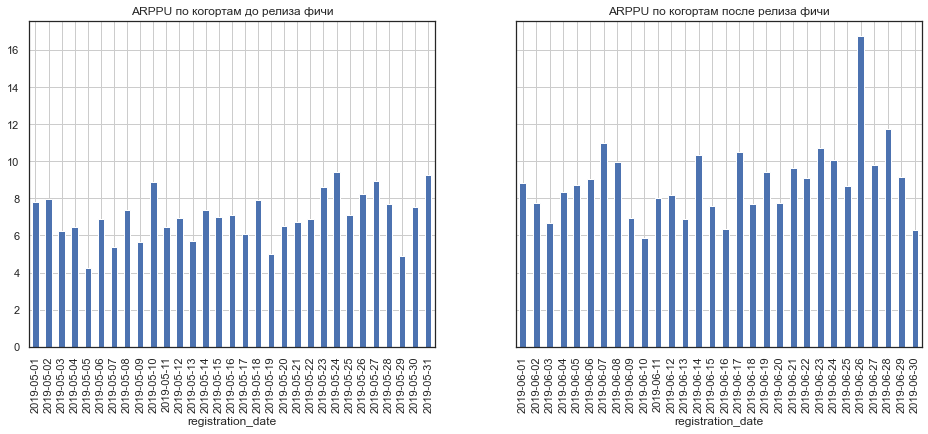

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey = True);
arppu_with_cohorts_05.arppu.plot.bar(title='ARPPU по когортам до релиза фичи',grid=True,ax=axes[0])
arppu_with_cohorts_06.arppu.plot.bar(title='ARPPU по когортам после релиза фичи',grid=True,ax=axes[1]);

Визуально средняя выручка с одного платящего пользователя увеличилась после релиза фичи. Посчитаем на сколько процентов

In [44]:
a=round(arppu_with_cohorts_06['arppu'].mean(),2)
b=round(arppu_with_cohorts_05['arppu'].mean(),2)
n=(a-b)/b
print(f'До релиза фичи средний ARPPU за месяц по когортам {b}$, после выхода фичи {a}$. \nПоказатель ARPPU увеличился на {n:.0%}') 

До релиза фичи средний ARPPU за месяц по когортам 7.04$, после выхода фичи 8.92$. 
Показатель ARPPU увеличился на 27%


Появление новой фичи - новостной ленты в личном кабинете пользователя - существенно не повлияло на возвращаемость пользователей в сервис. Показатель Retention Rate когорт на седьмой день до и после релиза фичи отличается незначительно.   
В мае, до релиза фичи, в сервисе зарегистрировалось 188943 пользователя, а в июне 100423 пользователя.

Сумма выручки, которую принесли пользователи: 
>  зарегистрировавшиеся в мае 121998.3 $

>  зарегистрировавшиеся в июне 79685.9 $

Тем не менее, показатель средней выручки от одного платящего клиента в месяц после релиза фичи оказался на 27% больше, чем в аналогичный период до релиза.

#### Таким образом, можно утверждать, что использование фичи эффективно. 